In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import dask.dataframe as dd
import dask
from collections import defaultdict
from pathlib import Path
import torch
from tqdm.notebook import tqdm


# Import our utility functions
sys.path.append('..')
from notebooks.file_structure_utils import (
    get_image_path,
    get_available_channels,
)

data_dir = '../../njwfish/DistributionEmbeddings/data/ops'

In [3]:
cols = ['gene_symbol_0', 'plate', 'tile', 'well', 'bounds_0', 'bounds_1', 'bounds_2', 'bounds_3']
pdf = pd.read_parquet(data_dir+'/interphase-reclassified_cp_phenotype_normalized.parquet', columns=cols)

In [ ]:
def build_crop_dict(parquet_df, n_imgs=50):
    
    df = parquet_df
 
    print('grouping by img, this takes ~1m')
    grouped = defaultdict(list)
    for row in df.itertuples():
        grouped[(row.plate, row.well, row.tile)].append((row.gene_symbol_0, row.bounds_0, row.bounds_1, 
                                                    row.bounds_2, row.bounds_3))

    pert_dict = defaultdict(list)

    for img_number, (img_path, entries) in tqdm(enumerate(grouped.items())):
        plate, well, tile = img_path
        available_channels = get_available_channels(plate, well, tile, base_dir=data_dir)
        
        if 'DAPI-GFP' in available_channels:
            image_path = get_image_path(plate, well, tile, 'DAPI-GFP', data_dir, 'screenA')
            
            # Check if file exists
            if not image_path or not os.path.exists(image_path):
                print(f"Warning: File not found")
                continue
                
            # Load full image
            full_image = io.imread(image_path)
            if len(full_image.shape) == 4 and full_image.shape[1] == 2:
                dapi_image = full_image[0, 0]
                gfp_image = full_image[0, 1]

                for ent in entries:

                    cell_images = {}
                    cell_images['DAPI'] = dapi_image[ent[1]:ent[3], ent[2]:ent[4]]
                    cell_images['GFP'] = gfp_image[ent[1]:ent[3], ent[2]:ent[4]]
                    pert_dict[ent[0]].append(torch.stack([torch.tensor(c) for c in cell_images.values()]))

        if img_number > n_imgs:
            break


        # find max shape
        H_max = max(x.shape[1] for v in pert_dict.values() for x in v)
        W_max = max(x.shape[2] for v in pert_dict.values() for x in v)

        print('max shape: %d, %d' %(H_max, W_max))

        # pad everything
        for k, crop_list in pert_dict.items():
            padded = []
            for t in crop_list:
                h, w = t.shape[1:]
                pad_h = H_max - h
                pad_w = W_max - w
                # pad as (left, right, top, bottom)
                padded_t = torch.nn.functional.pad(t, (0, pad_w, 0, pad_h))  # right + bottom pad only
                padded.append(padded_t)
            pert_dict[k] = padded

    return pert_dict  # {perturbation: [list of (2, h, w)]}

In [6]:
cd = build_crop_dict(pdf)

grouping by img, this takes ~1m


0it [00:00, ?it/s]

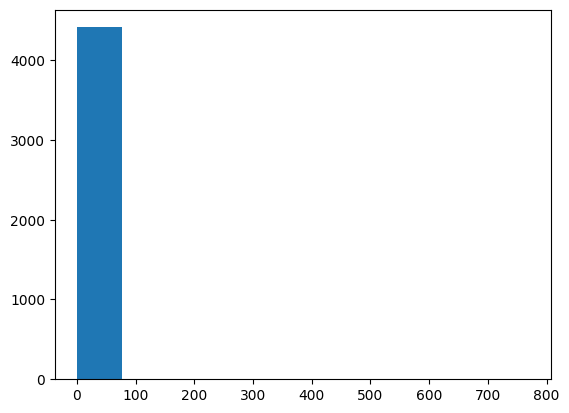

total cells:  31552
total perts:  4414
number of nontargeting:  769


In [17]:
counts = {k:len(v) for k,v in cd.items()}
plt.hist(list(counts.values()))
plt.show()

print('total cells: ', sum(list(counts.values())))
print('total perts: ', len(counts))
print('number of nontargeting: ', counts['nontargeting'])

DAPI:


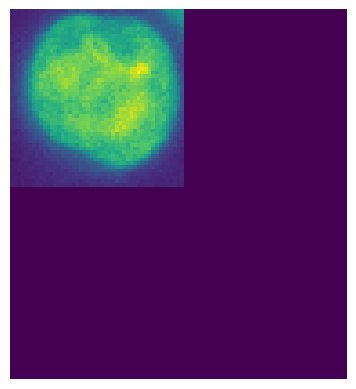

GFP:


(np.float64(-0.5), np.float64(92.5), np.float64(101.5), np.float64(-0.5))

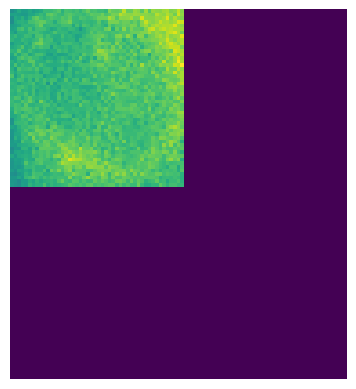

In [18]:
print('DAPI:')
plt.imshow(cd['CCNT1'][100][0, :, :])
plt.axis('off')
plt.show()
print('GFP:')
plt.imshow(cd['CCNT1'][100][1, :, :])
plt.axis('off')